In [143]:
import sys
import os
from features_extraction.harralick import Harralick
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import logging
from torchvision import transforms
from PIL import Image
import random
import math

In [3]:
'''
FUNGSI GENERAL PREPROCESSING UNTUK MELAKUKAN PREPROCESSING SECARA UMUM SEBELUM MASUK KE SPESIFIK PREPROCESSING
'''

def general_preprocessing(image_path):
    # Load image
    image = cv2.imread(image_path)
    
    # Konversi ke grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize image
    resize_image = cv2.resize(gray_image, (128,128), interpolation=cv2.INTER_CUBIC)
    
    return resize_image

In [4]:
# Kelas berdasarkan nama folder
classes = ["Overripe", "Ripe", "Unripe"]

# Menyimpan data gambar dan label
data = []
labels = []

# Iterasi setiap kelas
for label, category in enumerate(classes):
    folder_path = os.path.join('dataset', f'{category}/cropped')
    # print(folder_path)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # print(file_path)
        image = general_preprocessing(file_path)
        
        # Menyimpan data
        data.append(image)
        labels.append(label)

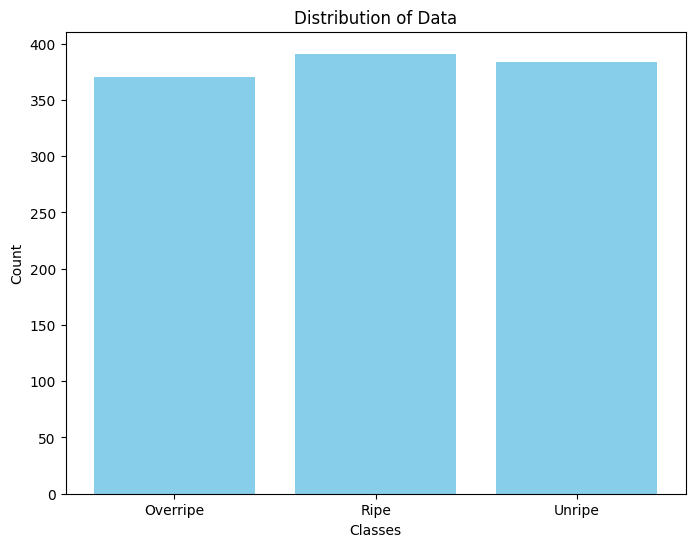

In [11]:
# Calculate the distribution of labels
label_counts = [np.sum(labels == i) for i in range(len(classes))]

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(classes, label_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Data')
plt.show()

In [6]:
# Konversi ke array NumPy
data = np.array(data, dtype="float32")
labels = np.array(labels)

print("Jumlah data:", len(data))
print("Jumlah label:", len(labels))

Jumlah data: 1145
Jumlah label: 1145


In [7]:
data = data.astype(np.uint16)
data.shape

(1145, 128, 128)

In [8]:
# Cek Nilai minimum dan maksimum
print(f"Nilai piksel minimum: {np.min(data)}")
print(f"Nilai piksel maksimum: {np.max(data)}")

Nilai piksel minimum: 0
Nilai piksel maksimum: 255


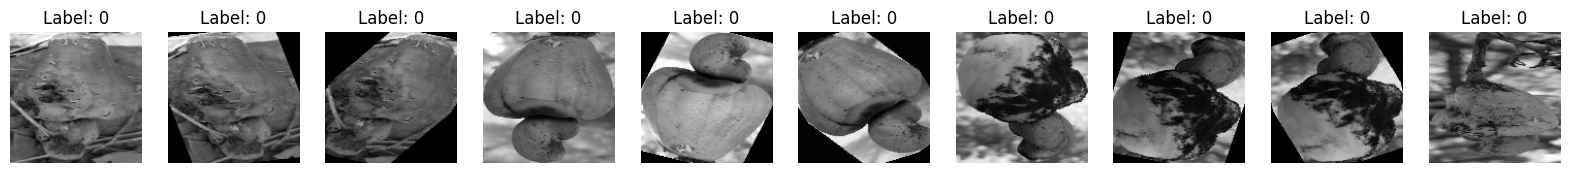

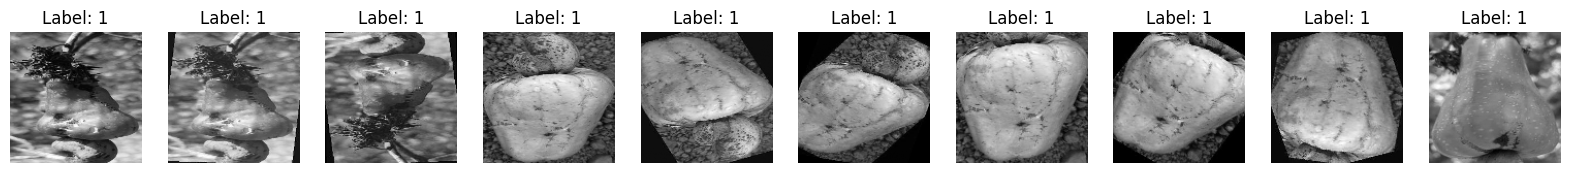

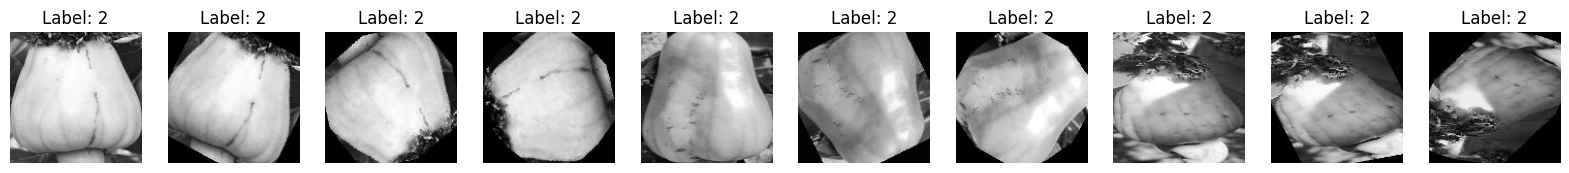

In [9]:
# Menampilkan 10 contoh gambar pertama
num_samples = 10
plt.figure(figsize=(20, 10))

# 10 Label 0 (Overripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 1 (Ripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[370+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[370+i]}")
    plt.axis("off")

plt.show()

plt.figure(figsize=(20, 10))
# 10 Label 2 (Unripe)
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(data[781+i], cmap="gray")  # cmap="gray" agar sesuai dengan grayscale
    plt.title(f"Label: {labels[781+i]}")
    plt.axis("off")

plt.show()

In [14]:
# Kombinasi d dan theta
kombinasiFeature = [[1, 2, 3], [0, 45, 90, 135]]
# kombinasiFeature = [[1], [0]]

# Dictionary to store DataFrames for each combination
feature_dataframes = {}

for d in kombinasiFeature[0]:
    for theta in kombinasiFeature[1]:
        data_fitur = []  # List untuk menyimpan fitur semua gambar untuk kombinasi ini
        img = 0  # Index untuk data
        for index in range(len(data)):
            try:
                # Inisialisasi objek GLCM dengan kombinasi d dan theta
                glcm_calculator = Harralick(d=d, theta=theta)

                # Hitung Matriks GLCM
                glcm_matrix = glcm_calculator.calculate_glcm(data[index])

                # Hitung semua fitur Harralick dari matriks GLCM
                features = glcm_calculator.get_all_features(glcm_matrix)

                # Tambahkan ID gambar dan label ke dictionary fitur
                features['image'] = f'img-{img}'
                features['label'] = labels[index]

                data_fitur.append(features)

                img += 1
            except Exception as e:
                print(e)

        # Simpan DataFrame ke dictionary untuk analisis lebih lanjut
        if data_fitur:
            df = pd.DataFrame(data_fitur)
            feature_dataframes[(d, theta)] = df
            print(f"Data untuk d={d}, theta={theta} berhasil dihitung dan disimpan ke dalam memori!")
        else:
            print(f"Tidak ada data untuk d={d}, theta={theta}. Tidak ada DataFrame yang dibuat.")

# Setelah semua kombinasi dihitung, Anda dapat menganalisis DataFrame di feature_dataframes
# Contoh analisis:
# print(feature_dataframes[(1, 0)].head())  # Menampilkan data untuk d=1, theta=0

Data untuk d=1, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=1, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=2, theta=135 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=0 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=45 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=90 berhasil dihitung dan disimpan ke dalam memori!
Data untuk d=3, theta=135 berhasil dihitung dan disimpan ke dalam memori!


In [15]:
feature_dataframes[(1, 0)]

,energy,contrast,correlation,variance,homogeneity,sum_average,sum_variance,sum_entropy,entropy,difference_variance,difference_entropy,information_measure_of_correlation1,information_measure_of_correlation2,max_correlation_coefficient,image,label
0,0.000436,110.166831,0.968410,1745.470091,0.278715,229.194882,19985.685932,11.764628,11.764628,11716.451490,11.764628,9.290623,9.290623,0.002092,img-0,0
1,0.003707,185.044845,0.955084,2067.488357,0.310510,172.035618,15465.268545,11.286891,11.286891,6304.576291,11.286891,8.856255,8.856255,0.056225,img-1,0
2,0.031999,122.675935,0.963039,1656.280969,0.416517,116.701403,9909.617267,9.898711,9.898711,2887.199510,9.898711,8.058422,8.058422,0.177165,img-2,0
3,0.000704,90.915170,0.974211,1780.597682,0.354354,243.089998,21789.987993,11.305699,11.305699,13606.942167,11.305699,8.842398,8.842398,0.009166,img-3,0
4,0.009164,412.338029,0.951060,4224.241207,0.360961,255.528113,32794.369367,11.062443,11.062443,14803.458480,11.062443,8.406406,8.406406,0.093442,img-4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,0.000352,127.108637,0.980937,3331.170542,0.318195,294.998893,34978.389007,11.913047,11.913047,20090.896376,11.913047,10.149232,10.149232,0.001292,img-1140,2
1141,0.002357,197.071112,0.973834,3767.564091,0.368618,247.956447,30249.317700,11.296681,11.296681,14082.826317,11.296681,9.154289,9.154289,0.042138,img-1141,2
1142,0.000557,117.482776,0.973535,2224.495793,0.332344,207.611097,19551.475417,11.571409,11.571409,9713.402563,11.571409,9.563411,9.563411,0.002768,img-1142,2
1143,0.009667,300.388472,0.958689,3636.108247,0.382094,172.255598,21654.086107,11.027578,11.027578,6534.393323,11.027578,8.326749,8.326749,0.095719,img-1143,2


In [56]:
feature_dataframes[(1, 0)].info() # Check data types and non-null counts

<class 'pandas.core.frame.DataFrame'>
Index: 1145 entries, img-0 to img-1144
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   energy                               1145 non-null   float64
 1   contrast                             1145 non-null   float64
 2   correlation                          1145 non-null   float64
 3   variance                             1145 non-null   float64
 4   homogeneity                          1145 non-null   float64
 5   sum_average                          1145 non-null   float64
 6   sum_variance                         1145 non-null   float64
 7   sum_entropy                          1145 non-null   float64
 8   entropy                              1145 non-null   float64
 9   difference_variance                  1145 non-null   float64
 10  difference_entropy                   1145 non-null   float64
 11  information_measure_of_corr

In [ ]:
feature_dataframes[(1, 0)].describe() # Summary statistics for numerical features

,energy,contrast,correlation,variance,homogeneity,sum_average,sum_variance,sum_entropy,entropy,difference_variance,difference_entropy,information_measure_of_correlation1,information_measure_of_correlation2,max_correlation_coefficient,label
count,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000,1145.000000
mean,0.006986,197.842770,0.966759,3277.662130,0.363213,255.223629,30086.203586,11.099962,11.099962,15669.896549,11.099962,8.544718,8.544718,0.049538,1.012227
std,0.013800,106.129077,0.018017,1526.386822,0.073779,59.643315,11035.076664,0.809511,0.809511,7150.945246,0.809511,1.061067,1.061067,0.060432,0.811752
min,0.000167,9.706324,0.830577,575.253813,0.187846,86.582247,5568.727904,7.022649,7.022649,1616.131415,7.022649,4.551341,4.551341,0.000738,0.000000
25%,0.000538,123.619771,0.958689,2161.492098,0.311467,214.006951,21459.542322,10.614070,10.614070,10195.098547,10.614070,7.825384,7.825384,0.003137,0.000000
50%,0.001334,177.925874,0.970754,3003.321793,0.360359,255.865834,29347.551984,11.159165,11.159165,14824.280255,11.159165,8.604178,8.604178,0.015440,1.000000
75%,0.009358,250.529343,0.979134,4037.113910,0.410552,299.144131,38125.774220,11.727376,11.727376,20276.880195,11.727376,9.345628,9.345628,0.090059,2.000000
max,0.199063,881.892778,0.998106,9419.332652,0.660068,410.738066,66504.129255,12.885294,12.885294,39941.618744,12.885294,10.959173,10.959173,0.445866,2.000000


In [329]:
df = feature_dataframes[(1, 0)].copy()

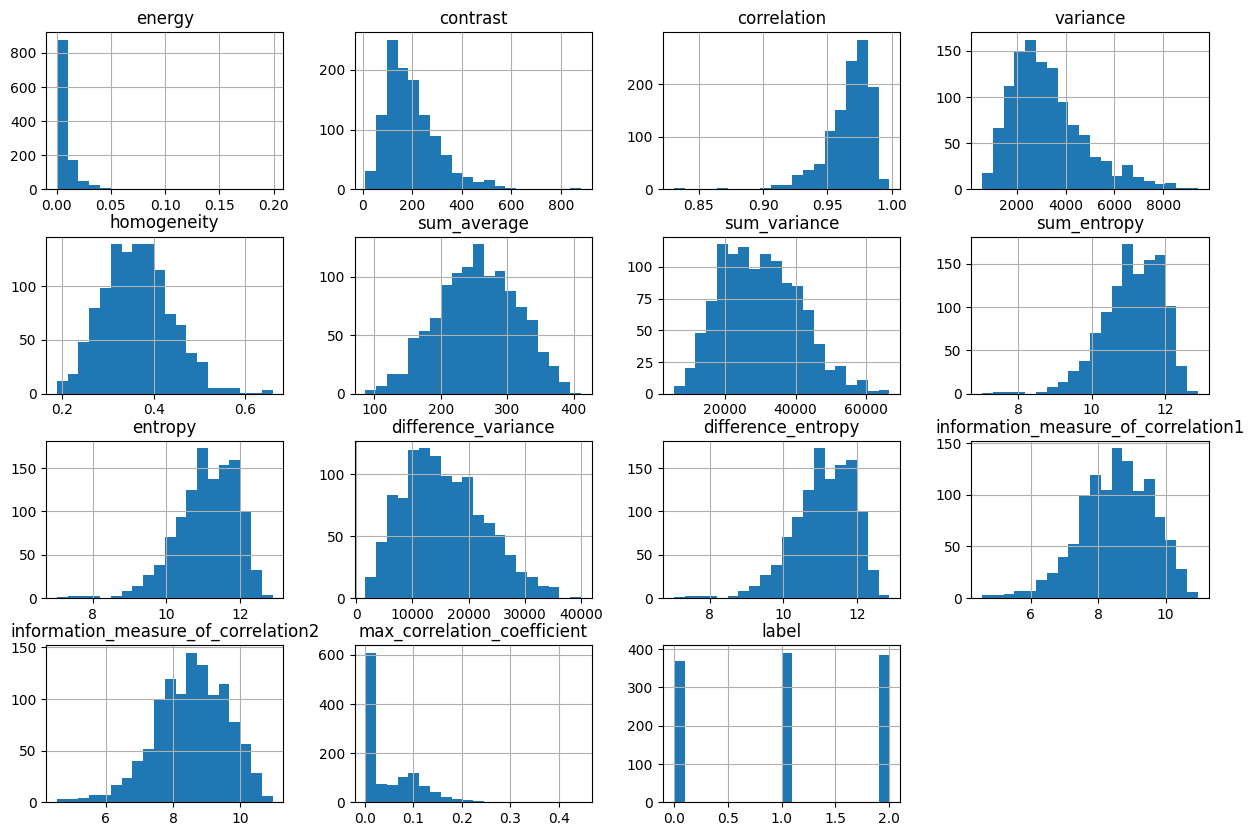

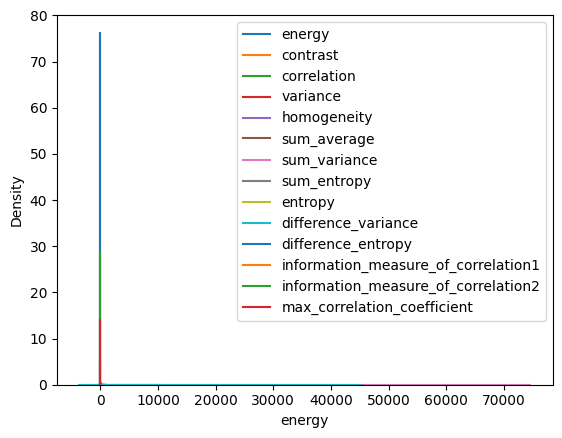

In [330]:
# Plot histograms for each feature
df.hist(bins=20, figsize=(15, 10))
plt.show()

# Plot density plots for selected features
for col in df.columns[:-1]:  # Exclude 'image' and 'label'
    sns.kdeplot(df[col], label=col)
plt.legend()
plt.show()

## Handling Outlier

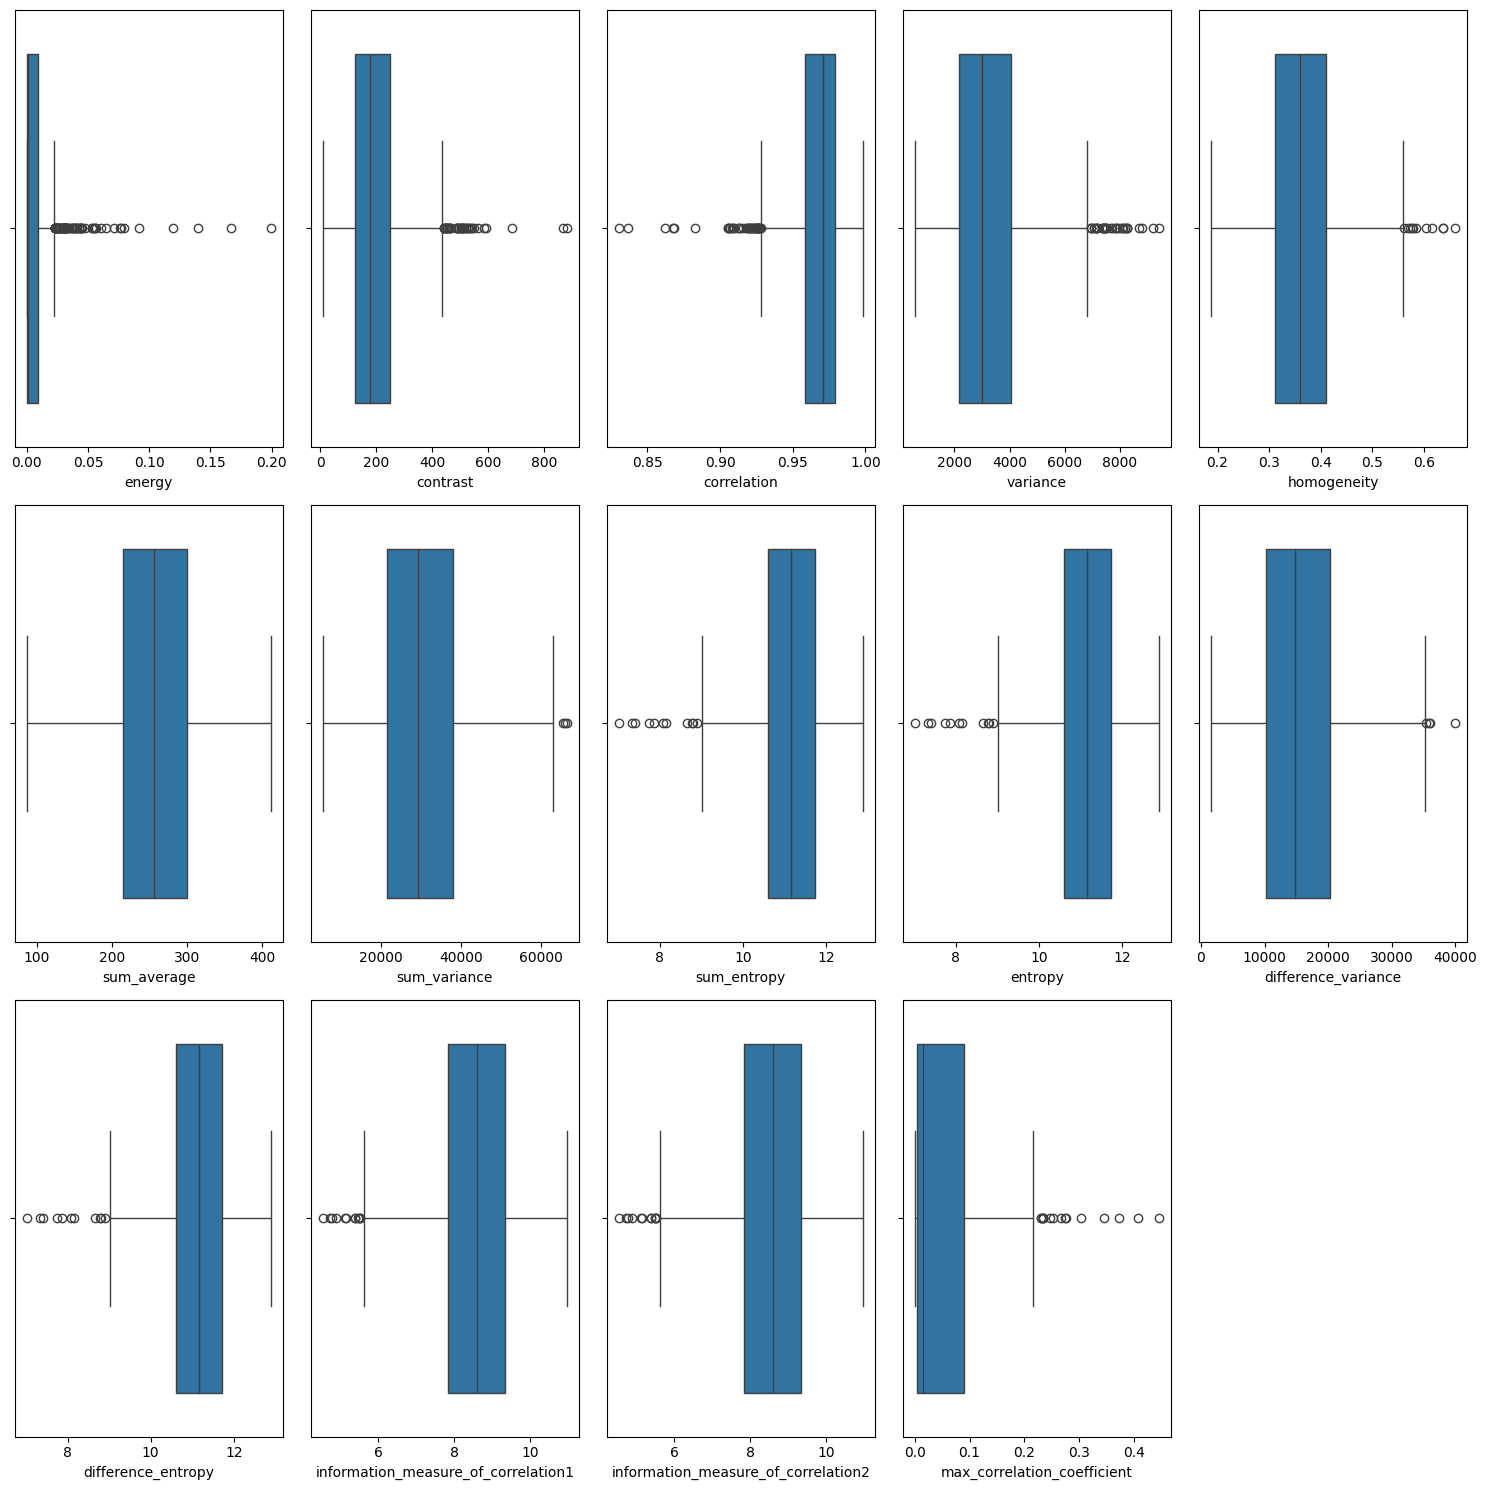

In [331]:
# Cek outlier dengan visualisasi dalam 3 baris
# Tentukan jumlah kolom per baris
cols_per_row = 5
num_features = len(df.columns[:-1])  # tanpa 'label'
num_rows = math.ceil(num_features / cols_per_row)  # Hitung jumlah baris

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten untuk iterasi yang mudah

for i, col in enumerate(df.columns[:-1]):  # tanpa 'label'
    sns.boxplot(x=df[col], ax=axes[i])
    # axes[i].set_title(f"Outliers in Feature: {col}")

# Hapus subplot kosong jika jumlah fitur tidak habis dibagi jumlah kolom
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Terlihat pada setiap fitur ada outliernya dan hanya fitur sum_average saja yang tidak memiliki nilai outlier, maka dari itu perlu dilakukan pengolahan data untuk menghilangkan outlier tersebut. 
Teknik yang akan digunakan di sini adalah *Interquartil Range* 

Mengumpulkan kelompok fitur berdasarkan distribusinya

In [332]:
# Mengelompokkan fitur berdasarkan skewness
right_skew = ['energy', 'contrast', 'variance', 'homogeneity', 'sum_variance', 'difference_variance', 'max_correlation_coefficient']
left_skew = ['correlation', 'sum_entropy', 'entropy', 'difference_entropy', 'information_measure_of_correlation1', 'information_measure_of_correlation2']

len(right_skew), len(left_skew)

(7, 6)

Akan dilakukan proses pengisian outlier dengan teknik *Imputation*

In [333]:
# Fungsi untuk proses imputation
def handle_asymmetric_outliers(series, lower_factor=1.5, upper_factor=1.5):
    """
    Menangani outlier asimetris dalam kolom Pandas Series.

    Args:
        series (pd.Series): Pandas Series yang akan diproses.
        lower_factor (float): Faktor IQR untuk batas bawah.
        upper_factor (float): Faktor IQR untuk batas atas.

    Returns:
        pd.Series: Pandas Series dengan outlier yang sudah ditangani.
    """

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (lower_factor * IQR)
    upper_bound = Q3 + (upper_factor * IQR)

    modified_series = np.where(series < lower_bound, lower_bound, series)
    modified_series = np.where(modified_series > upper_bound, upper_bound, modified_series)

    return modified_series

In [334]:
# Proses imputation untuk outlier ekstrem
for feature in right_skew + left_skew:
    # Sesuaikan nilai outlier
    df[feature] = handle_asymmetric_outliers(df[feature], lower_factor=1.5, upper_factor=1.5)

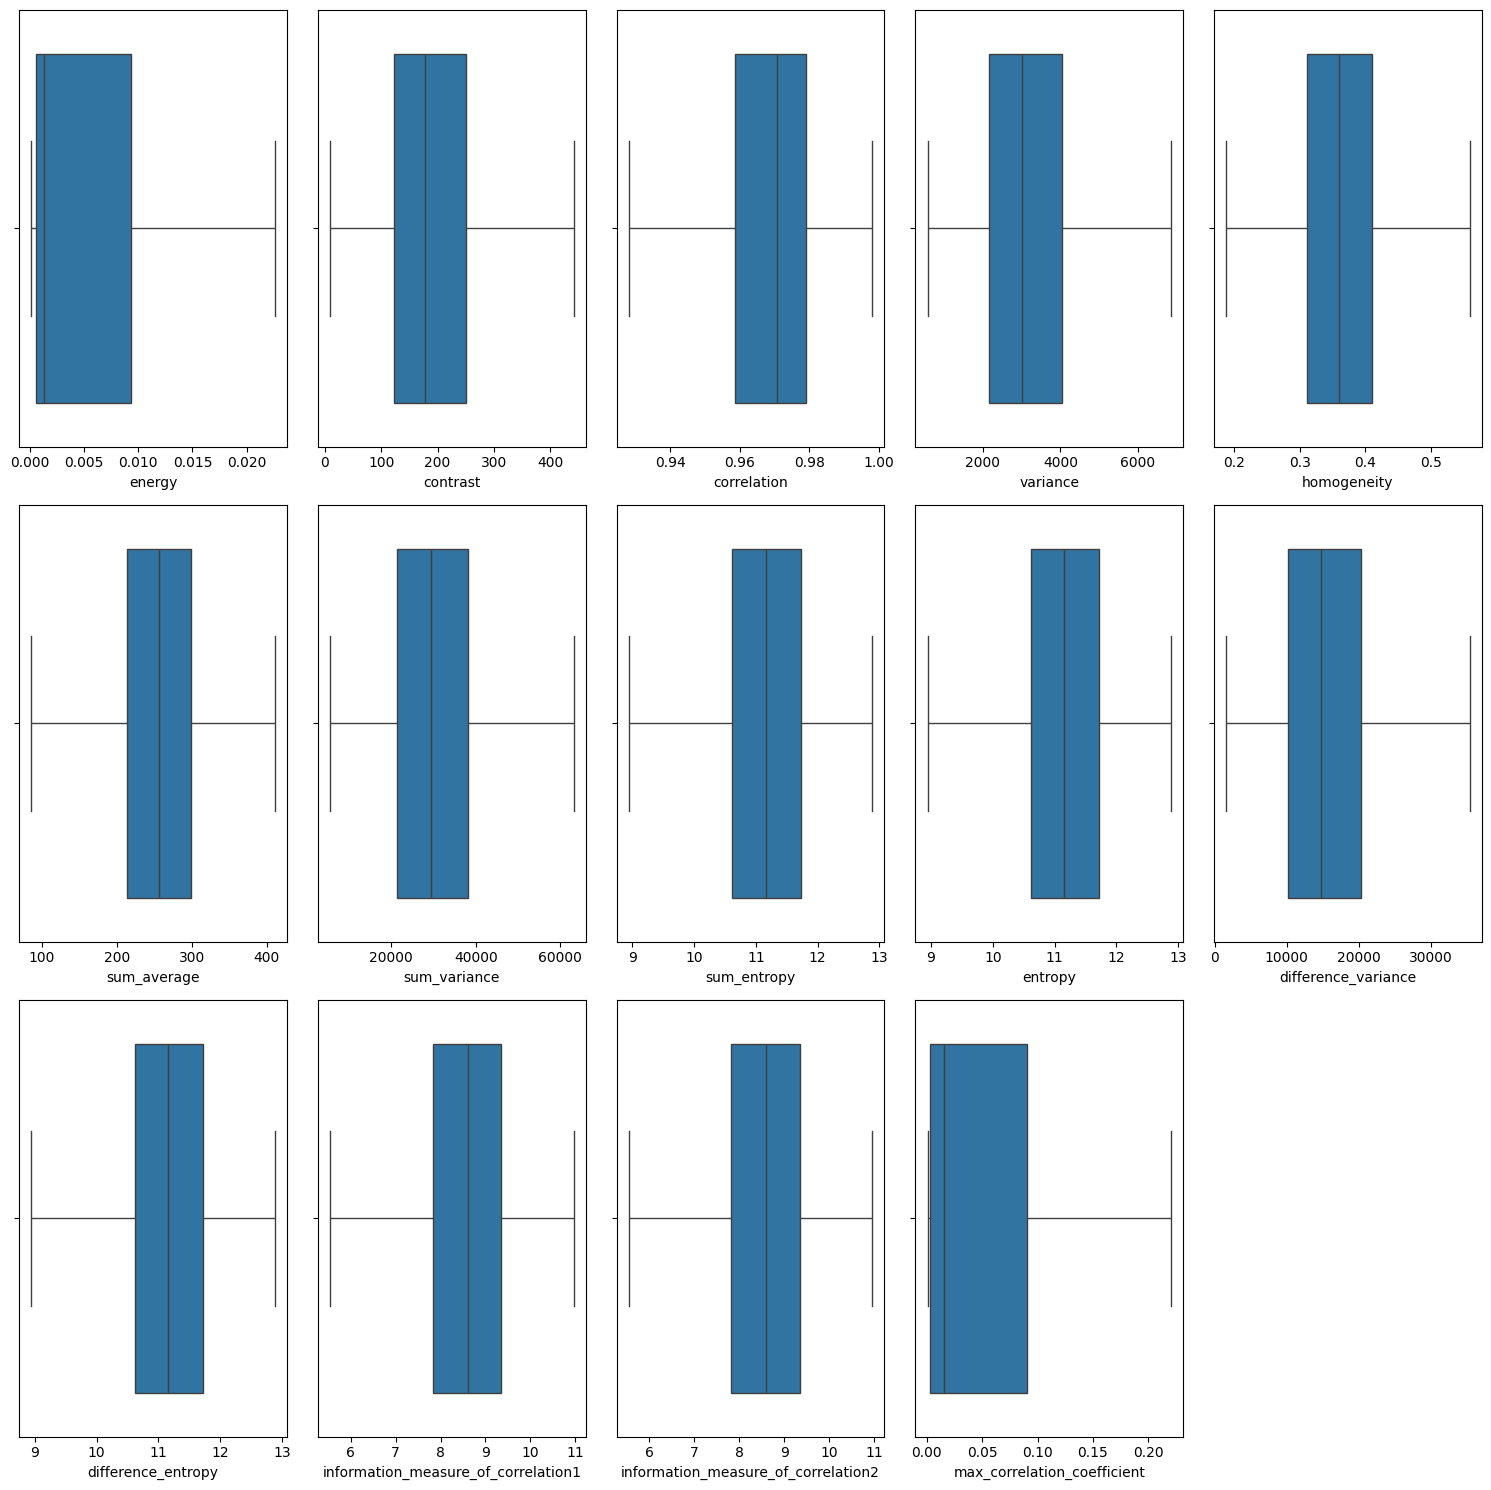

In [335]:
# Cek kembali box plot untuk melihat hasil imputation
cols_per_row = 5
num_features = len(df.columns[:-1])  # tanpa 'label'
num_rows = math.ceil(num_features / cols_per_row)  # Hitung jumlah baris

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten untuk iterasi yang mudah

for i, col in enumerate(df.columns[:-1]):  # tanpa 'label'
    sns.boxplot(x=df[col], ax=axes[i])
    # axes[i].set_title(f"Outliers in Feature: {col}")

# Hapus subplot kosong jika jumlah fitur tidak habis dibagi jumlah kolom
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Terlihat Outlier sudah hilang, sekarang akan dilanjutkan ke proses selanjutnya.

## Transform & Normalize

Sekarang mari cek lagi sebaran datanya

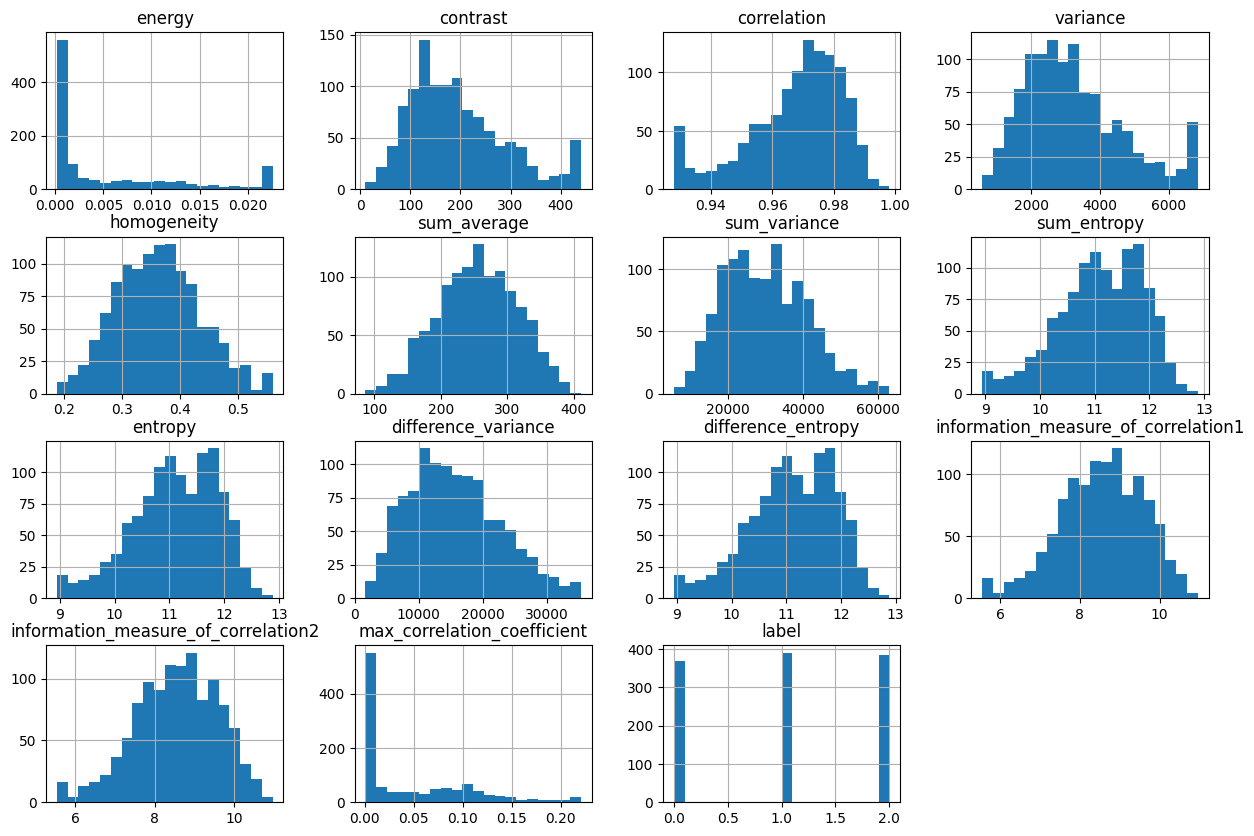

In [336]:
# Plot histograms for each feature
df.hist(bins=20, figsize=(15, 10))
plt.show()

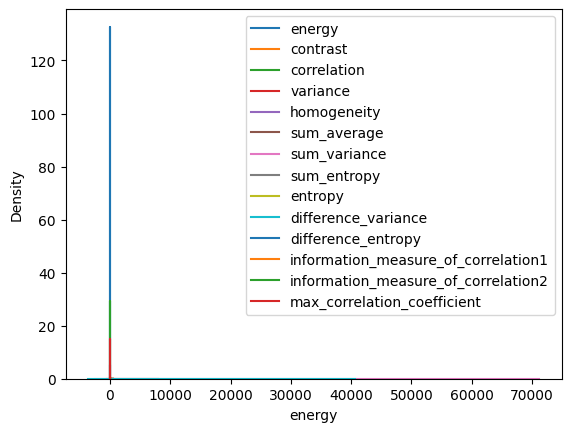

In [337]:
# Plot density plots for selected features
for col in df.columns[:-1]:  # Exclude'label'
    sns.kdeplot(df[col], label=col)
plt.legend()
plt.show()

Karena sebaran datanya rangenya itu berbeda jauh, maka akan dinormalisasi. Selain itu, akan digunakan model KNN pada fitur-fitur ini sehingga diperlukan normalisasi karena KNN sensitif terhadap skala data. Akan digunakan min-max scaler untuk mengubah skala data menjadi antara 0 dan 1.

In [338]:
# Cek skewness
skewness = df.skew()
print(skewness)

energy                                 1.299983
contrast                               0.789142
correlation                           -0.851545
variance                               0.750750
homogeneity                            0.245276
sum_average                           -0.115849
sum_variance                           0.360879
sum_entropy                           -0.514850
entropy                               -0.514850
difference_variance                    0.436200
difference_entropy                    -0.514850
information_measure_of_correlation1   -0.362091
information_measure_of_correlation2   -0.362091
max_correlation_coefficient            1.096246
label                                 -0.022351
dtype: float64


In [339]:
# Normalisasi dengan Min-Max Scaling
numeric_features = df.columns[:-1]

df_transform = df.copy()
scaler = MinMaxScaler()
df_transform[numeric_features] = scaler.fit_transform(df_transform[numeric_features])

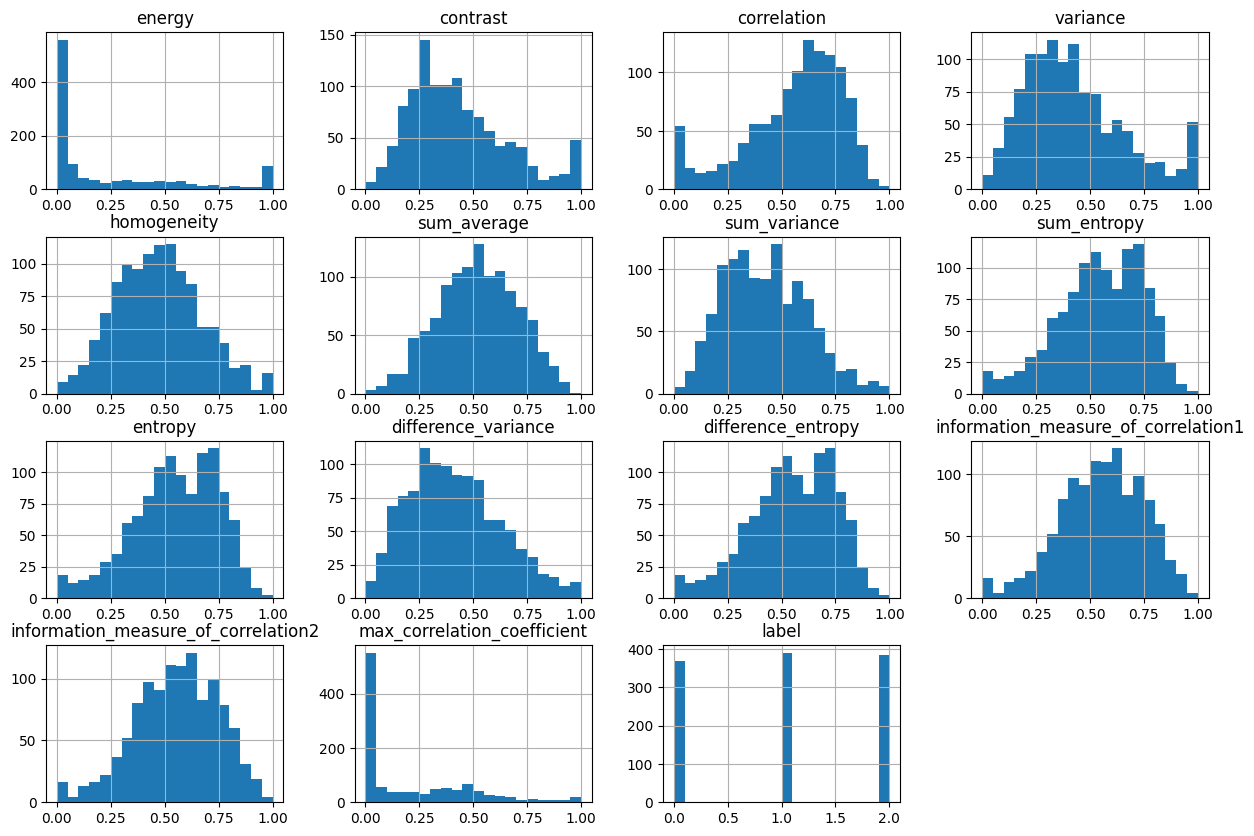

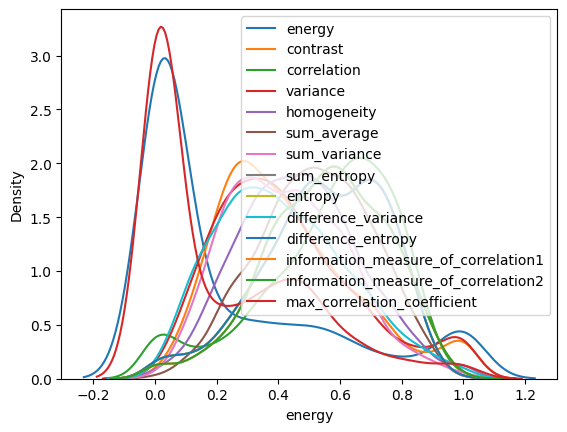

In [340]:
# Plot histograms for each feature
df_transform.hist(bins=20, figsize=(15, 10))
plt.show()

# Plot density plots for selected features
for col in df_transform.columns[:-1]:  # Exclude'label'
    sns.kdeplot(df_transform[col], label=col)
plt.legend()
plt.show()

In [341]:
def log_transform(series, add_constant=True):
    """
    Melakukan transformasi logaritma pada Pandas Series.

    Args:
        series (pd.Series): Pandas Series yang akan ditransformasi.
        add_constant (bool): Menambahkan konstanta kecil jika ada nilai nol atau negatif.

    Returns:
        pd.Series: Pandas Series yang ditransformasi.
    """

    if add_constant and (series <= 0).any():
        min_positive = series[series > 0].min()
        series = series + min_positive

    transformed_series = np.log10(series)
    return transformed_series

In [342]:
# Step 2: Apply log transformation (handle zeros by adding a small constant)
df_log_transformed = df_transform.copy()
 # log1p(x) = log(1 + x)# Applying Square Root Transformation
df_log_transformed['energy'] = log_transform(df_log_transformed['energy'])
df_log_transformed['max_correlation_coefficient'] = log_transform(df_log_transformed['max_correlation_coefficient'])

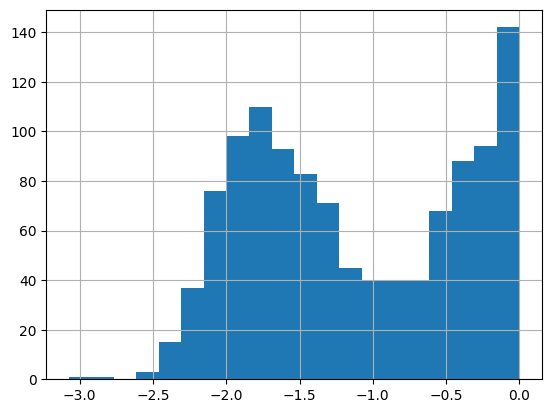

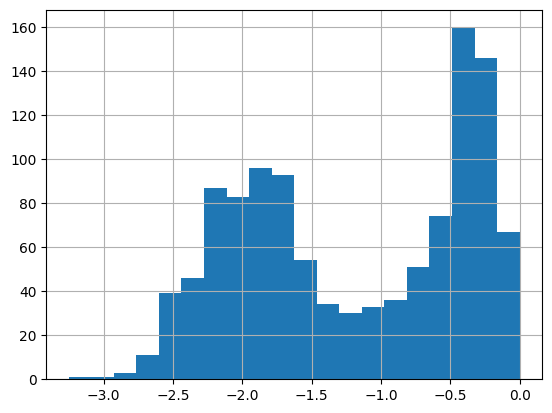

In [343]:
df_log_transformed['energy'].hist(bins=20)
plt.show()
df_log_transformed['max_correlation_coefficient'].hist(bins=20)
plt.show()

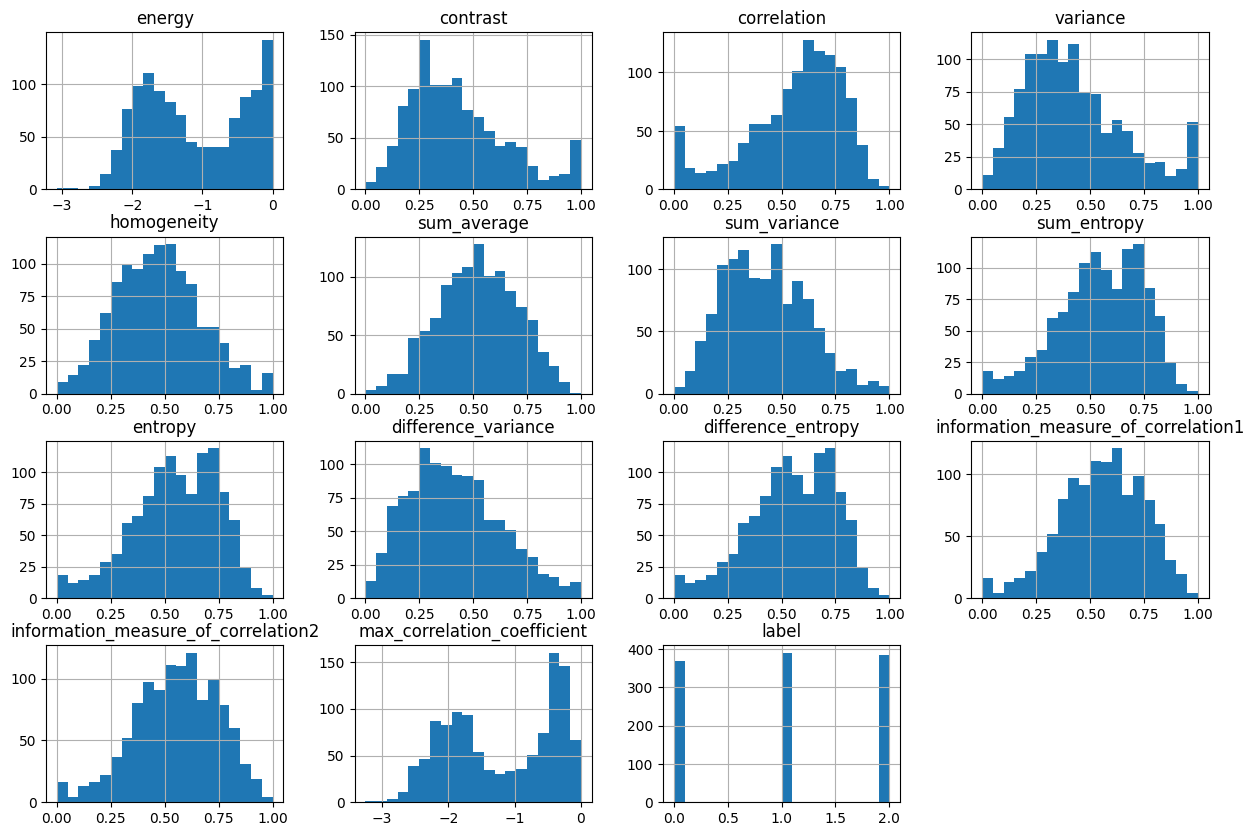

In [312]:
df_log_transformed.hist(bins=20, figsize=(15, 10))
plt.show()

In [325]:
testtt = df_log_transformed.columns[:-1]
df_log_transformed[testtt] = scaler.fit_transform(df_log_transformed[testtt])


In [317]:
from classifier.knn import KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [358]:
ngetest = df_log_transformed.copy()
ngetest = ngetest.drop(columns=['difference_entropy', 'information_measure_of_correlation1', 'sum_entropy', 'energy','max_correlation_coefficient'])
ngetest

,contrast,correlation,variance,homogeneity,sum_average,sum_variance,entropy,difference_variance,information_measure_of_correlation2,label
image,,,,,,,,,,
img-0,0.232986,0.576284,0.186480,0.244709,0.439951,0.250484,0.715652,0.298973,0.691817,0
img-1,0.406641,0.386135,0.237795,0.330335,0.263618,0.171945,0.594436,0.138779,0.611589,0
img-2,0.261997,0.499639,0.172267,0.615811,0.092916,0.075420,0.242212,0.037624,0.464228,0
img-3,0.188338,0.659057,0.192078,0.448405,0.482816,0.281832,0.599208,0.354932,0.609029,0
img-4,0.933774,0.328721,0.581485,0.466199,0.521187,0.473025,0.537486,0.390349,0.528501,0
...,...,...,...,...,...,...,...,...,...,...
img-1140,0.272277,0.755024,0.439169,0.351031,0.642952,0.510971,0.753311,0.546859,0.850403,2
img-1141,0.434532,0.653675,0.508711,0.486818,0.497829,0.428807,0.596920,0.369018,0.666636,2
img-1142,0.249953,0.649414,0.262815,0.389132,0.373366,0.242940,0.666627,0.239682,0.742201,2


In [359]:
X_train, X_test, y_train, y_test = train_test_split(ngetest.drop(columns=['label']), ngetest['label'], test_size=0.2, random_state=42)

In [360]:
for k in range(3, 4):  # Mencoba k dari 3 sampai 15
    model = KNN(k=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(acc, prec, rec, f1)

0.4759825327510917 0.48154627242594833 0.4759825327510917 0.4756137797185832
